In [293]:
import numpy as np
import wandb

In [294]:
''' MLP class  '''

class MLP:
    ''' Multi-layer perceptron class '''
    ''' input_size, hidden_layers = [sizes of the hidden layers], output_size, epochs, learning_rate, batch_size, activation_function, loss_function '''
    def __init__(self, input_size, hidden_layers, output_size, epochs = 100, learning_rate = 0.01, early_stopping = False,
                 batch_size = 32, activation_function = 'relu', loss_function = 'mse', optimizer = 'sgd', beta = 0.0, 
                 Random_state = None, weight_init = 'he', model_type = 'class_ML', wandb_vaar = False, run_start = "hyperparam_tuning"):
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.beta = beta
        self.weight_init = weight_init
        self.model_type = model_type
        self.wandb_vaar = wandb_vaar
        
        self.weights = []
        self.biases = []
        self.loss = []
        self.history = []
        
        np.random.seed(Random_state)
        
        self._initialize_weights()
        
        run_name = f"{run_start}-{self.activation_function}-{self.optimizer}-{self.loss_function}-{self.weight_init}-{self.epochs}-{self.learning_rate}-{self.batch_size}"
        
        # Initialize WandB
        if wandb_vaar:
            wandb.init(
                project="SMAI_A3-MLP_MultiLable", 
                name=run_name,
                config={
                "learning_rate": self.learning_rate,
                "epochs": self.epochs,
                "batch_size": self.batch_size,
                "activation": self.activation_function,
                "optimizer": self.optimizer,
                "input_size": self.input_size,
                "hidden_layer_sizes": self.hidden_layers,
                "output_size": self.output_size,
                "loss_function": self.loss_function,
                "weight_init": self.weight_init,
                "Random_state": Random_state,
                "beta": self.beta,
                "early_stopping": self.early_stopping,
            })
        
    def _initialize_weights(self):
        ''' Initialize weights '''
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layers) - 1):
            if self.weight_init == 'random':
                self.weights.append(np.random.randn(layers[i], layers[i+1]))  # Random initialization
            
            elif self.weight_init == 'he':
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2. / layers[i]))  # He initialization
            
            elif self.weight_init == 'xavier':
                limit = np.sqrt(6 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (layers[i], layers[i+1])))  # Xavier/Glorot initialization
            
            self.biases.append(np.zeros(layers[i+1]))
        
        self.vW = [np.zeros_like(w) for w in self.weights]  # Initialize velocity for weights
        self.vb = [np.zeros_like(b) for b in self.biases]   # Initialize velocity for biases
    
    # Activation functions       
    def relu(self, x):
        ''' ReLU activation function '''
        return np.where(x > 0, x, x * 0.01)
    def relu_derivative(self, x):
        ''' ReLU derivative '''
        return np.where(x > 0, 1, 0.01)
    
    def sigmoid(self, x):
        ''' Sigmoid activation function '''
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x):
        ''' Sigmoid derivative '''
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        ''' Tanh activation function '''
        return np.tanh(x)
    def tanh_derivative(self, x):
        ''' Tanh derivative '''
        return 1 - np.tanh(x)**2
    
    def linear(self, x):
        ''' Linear activation function '''
        return x
    def linear_derivative(self, x):
        ''' Linear derivative '''
        return 1
            
    def _activation(self, activation_function = None):
        ''' Activation function '''
        if activation_function == 'relu':
            return self.relu, self.relu_derivative
        elif activation_function == 'sigmoid':
            return self.sigmoid, self.sigmoid_derivative
        elif activation_function == 'tanh':
            return self.tanh, self.tanh_derivative
        elif activation_function == 'linear':
            return self.linear, self.linear_derivative
        else:
            raise ValueError('Activation function not supported')
    
    # Optimizers
    def mse(self, y, y_pred):
        ''' Mean squared error '''
        return np.mean((y - y_pred)**2)
    def mse_derivative(self, y, y_pred):
        ''' Mean squared error derivative '''
        return 2*(y_pred - y)
    
    def cross_entropy(self, y, y_pred):
        ''' Cross entropy loss '''
        return -np.sum(y * np.log(y_pred)) / len(y)
    
    def cross_entropy_derivative(self, y, y_pred):
        ''' Cross entropy derivative '''
        return (y_pred - y) # / (y_pred * (1 - y_pred) + 1e-6)  
    
    def _loss(self):
        ''' Loss function '''
        if self.loss_function == 'mse':
            return self.mse, self.mse_derivative
        elif self.loss_function == 'cross_entropy':
            return self.cross_entropy, self.cross_entropy_derivative
        else:
            raise ValueError('Loss function not supported')
        
    def _softmax(self, x):
        ''' Softmax activation function '''
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def _one_hot(self, y):
        ''' One-hot encoding '''
        print(y.min(), y.max())
        one_hot = np.zeros((y.size, y.max()+1- y.min()))
        for i in range(y.size):
            one_hot[i, y[i] - y.min()] = 1
        return one_hot
    
    def filter_onehot(self, y_true, y_test):
        y_true = np.argmax(y_true, axis=1)
        y_test = np.argmax(y_test, axis=1)
        return y_true, y_test
    
    def filter_softmax(self, y_pred):
        # if >0.5, then 1 else 0
        return np.where(y_pred > 0.5, 1, 0)
        
    
    def accuracy(self, y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def hamming_loss(self, y_true, y_pred):
        # Compute the number of incorrectly predicted labels
        incorrect_labels = np.sum(y_true != y_pred)
        
        # Total number of labels is the number of samples times the number of labels per sample
        total_labels = y_true.shape[0] * y_true.shape[1]
        
        # Hamming Loss: Proportion of incorrect labels
        return incorrect_labels / total_labels
    
    def multi_label_partial_accuracy(self, y_true, y_pred):
        y_pred_partial = y_pred.reshape(-1, 1)
        y_true_partial = y_true.reshape(-1, 1)
        partial_accuracy = self.accuracy(y_true_partial, y_pred_partial)
        return partial_accuracy
    
    def multi_label_accuracy(y_true, y_pred):
        # Exact match accuracy (where all labels for a sample are correctly predicted)
        correct_predictions = np.sum(np.all(y_true == y_pred, axis=1))
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def multi_label_confusion_matrix(self, y_true, y_pred):
        num_labels = y_true.shape[1]
        confusion_matrices = []

        for i in range(num_labels):
            tp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 1))  # True Positive
            tn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 0))  # True Negative
            fp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 0))  # False Positive
            fn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 1))  # False Negative

            matrix = np.array([[tn, fp], [fn, tp]])
            confusion_matrices.append(matrix)

        return np.array(confusion_matrices)
    
    def multi_label_micro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # micro-averaged precision, recall, f1_score
        micro_precision = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 0]))
        micro_recall = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 1]))
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
        
        return micro_precision, micro_recall, micro_f1_score
    
    def multi_label_macro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # macro-averaged precision, recall, f1_score
        macro_precision = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 0]))
        macro_recall = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 1]))
        macro_f1_score = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        
        return macro_precision, macro_recall, macro_f1_score
    
    def multi_label_precision_recall_f1(y_true, y_pred):
        epsilon = 1e-9  # To avoid division by zero

        # True Positives, False Positives, and False Negatives for each label
        true_positives = np.sum((y_pred == 1) & (y_true == 1), axis=0)
        false_positives = np.sum((y_pred == 1) & (y_true == 0), axis=0)
        false_negatives = np.sum((y_pred == 0) & (y_true == 1), axis=0)

        # Precision: TP / (TP + FP)
        precision = true_positives / (true_positives + false_positives + epsilon)
        
        # Recall: TP / (TP + FN)
        recall = true_positives / (true_positives + false_negatives + epsilon)
        
        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        # Return macro-average (mean over all labels)
        return precision, recall, f1
    
    def confusion_matrix(self, y_true, y_pred):
        classes = np.unique(y_true)
        matrix = np.zeros((len(classes), len(classes)), dtype=int)

        for i in range(len(y_true)):
            true_idx = np.where(classes == y_true[i])[0][0]
            pred_idx = np.where(classes == y_pred[i])[0][0]
            matrix[true_idx, pred_idx] += 1
        
        return matrix
    
    def recall(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        recall_values = np.diag(matrix) / np.sum(matrix, axis=1)  # TP / (TP + FN)
        recall_values = np.nan_to_num(recall_values)  # Handle division by zero
        return np.mean(recall_values)
    
    def precision(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        precision_values = np.diag(matrix) / np.sum(matrix, axis=0)  # TP / (TP + FP)
        precision_values = np.nan_to_num(precision_values)  # Handle division by zero
        return np.mean(precision_values)
    
    def f1_score(self, y_true, y_pred):
        prec = self.precision(y_true, y_pred)
        rec = self.recall(y_true, y_pred)
        if (prec + rec) == 0:
            return 0
        return 2 * (prec * rec) / (prec + rec)
    
    def model_functions(self):
        if self.model_type == 'class_ML':
            return self.sigmoid, self.sigmoid_derivative
        elif self.model_type == 'class_MC':
            return self._softmax, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            return self._activation(self.activation_function)
    
    # Forward pass
    def forward(self, X):
        ''' Forward pass '''
        activations = [X]
        Z = [X]
        
        activation, _ = self._activation(self.activation_function)
        current_activation = X
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(current_activation, self.weights[i]) + self.biases[i]
            Z.append(z)
            current_activation = activation(z)
            activations.append(current_activation)
            
        # Output layer
        z = np.dot(current_activation, self.weights[-1]) + self.biases[-1]
        Z.append(z)
        
        # Check if the model is for classification or regression
        activation_function, _ = self.model_functions()
        # output_activation = self.relu(z) # Output activation function
        output_activation = activation_function(z) # Output activation function
        activations.append(output_activation)
        self.activations = activations
        
        return Z, activations
    
    # Backward pass
    def backward(self, X, y, Z, activations):
        ''' Backward pass '''
        grads = {}
        m = y.shape[0]
        
        # Activation function
        # activation_function, activation_derivative = self._activation(self.activation_function)
        activation_function, activation_derivative = self.model_functions()
        
        # Loss function
        # loss, loss_derivative = self._loss()
        if self.model_type == 'class_ML':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'class_MC':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            loss, loss_derivative = self.mse, self.mse_derivative
        
        # backprop loss in output layer
        dA = loss_derivative(y, (activations[-1]))
        if self.model_type == 'class_MC':
            dZ = (activations[-1] - y) / m
        else:
            dZ = dA * activation_derivative(Z[-1])
        
        grads["dW" + str(len(self.weights)-1)] = np.dot(activations[-2].T, dZ) / m
        grads["db" + str(len(self.weights)-1)] = np.sum(dZ, axis=0) / m
        
        # backprop hidden layers
        activation_function, activation_derivative = self._activation(self.activation_function)
        for i in range(len(self.weights)-2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * activation_derivative(Z[i+1])
            grads["dW" + str(i)] = np.dot(activations[i].T, dZ) / m
            grads["db" + str(i)] = np.sum(dZ, axis=0) / m
            
        return grads
    
    # # Update weights
    # def update_weights(self, grads):
    #     ''' Update weights '''
    #     # print('weights:', len(self.weights))
    #     # for i in range(len(self.weights)):
    #     #     print(self.weights[i].shape, grads["dW" + str(i)].shape)
    #     for i in range(len(self.weights)):
    #         self.weights[i] -= self.learning_rate * grads["dW" + str(i)]
    #         self.biases[i] -= self.learning_rate * grads["db" + str(i)]
    
    # update weights using momentum
    def update_weights(self, grads):
        for i in range(len(self.weights)):
            # Update the velocity for weights and biases using momentum
            self.vW[i] = self.beta * self.vW[i] + (1 - self.beta) * grads["dW" + str(i)]
            self.vb[i] = self.beta * self.vb[i] + (1 - self.beta) * grads["db" + str(i)]
            
            # Update the weights and biases using velocity
            self.weights[i] -= self.learning_rate * self.vW[i]
            self.biases[i] -= self.learning_rate * self.vb[i]
            
    # Train the model
    def fit(self, X, y):
        # encode the target variable if it is not regression
        # if not self.model_type == 'regression':
        #     y = self._one_hot(y)
        
        ''' Train the model '''
        for epoch in range(self.epochs):
            self.optimize(X, y)
            
            # Loss
            loss_func, loss_derivative = self._loss()
            y_pred = self.forward(X)[1][-1] # Predictions
            self.loss.append(loss_func(y, y_pred))
            
            # Log accuracy, recall, precision, f1_score
            if not self.model_type == 'regression' and self.wandb_vaar:
                y_true, y_pred = self.filter_onehot(y, y_pred)
                accuracy = self.accuracy(y_true, y_pred)
                recall = self.recall(y_true, y_pred)
                precision = self.precision(y_true, y_pred)
                f1_score = self.f1_score(y_true, y_pred)
                
            
            if self.wandb_vaar and self.wandb_vaar and not self.model_type == 'regression':
                wandb.log({"epoch":epoch+1, "loss": self.loss[-1], "accuracy": accuracy, "recall": recall, "precision": precision, "f1_score": f1_score})
            elif self.wandb_vaar:
                wandb.log({"epoch":epoch+1, "loss": self.loss[-1]})
            
            if self.early_stopping:
                if len(self.loss) > 1 and abs(self.loss[-1] - self.loss[-2]) < 1e-6:
                    print(f"Converged after {epoch+1} epochs")
                    break
        
        if self.wandb_vaar:
            wandb.finish()
            
    # Optimize
    def optimize(self, X, y):
        ''' Optimize the model '''
        if self.optimizer == 'sgd':
            self.sgd(X, y)
        elif self.optimizer == 'mini_batch':
            self.mini_batch(X, y)
        elif self.optimizer == 'full_batch':
            self.batch(X, y)
        else:
            raise ValueError('Optimizer not supported')
    
    def sgd(self, X, y):
        ''' Stochastic gradient descent '''
        for i in range(X.shape[0]):
            Z, activations = self.forward(X[i])
            
            # Adjust the sizes of matrix
            for j in range(len(activations)):
                activations[j] = activations[j].reshape(1, -1)
                Z[j] = Z[j].reshape(1, -1)
            
            grads = self.backward(X[i], y[i].reshape(1,-1), Z, activations)
            self.update_weights(grads)
    
    def mini_batch(self, X, y):
        ''' Mini-batch gradient descent '''
        for i in range(0, X.shape[0], self.batch_size):
            Z, activations = self.forward(X[i:i+self.batch_size])
            grads = self.backward(X[i:i+self.batch_size], y[i:i+self.batch_size], Z, activations)
            self.update_weights(grads)
            
    def batch(self, X, y):
        ''' Batch gradient descent '''
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        self.update_weights(grads)
        
    # Predict
    def predict(self, X):
        ''' Predict '''
        Z, activations = self.forward(X)
        return activations[-1]
    
    # Evaluate
    def evaluate(self, X, y):
        ''' Evaluate '''
        y_pred = self.predict(X)
        loss, _ = self._loss()
        return loss(y, y_pred)
    
    def _compute_loss(self, X, y):
        ''' Compute loss '''
        Z, activations = self.forward(X)
        loss, _ = self._loss()
        return loss(y, activations[-1])
    
    # gradient checks
    def check_gradients(self, X, y):
        ''' Gradient checks '''
        epsilon = 1e-4
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        
        numerical_grads_list = []
        analytical_grads_list = []
        
        # Check gradients
        for i in range(len(self.weights)):
            numerical_grads = np.zeros_like(self.weights[i])
            for j in range(self.weights[i].shape[0]):
                for k in range(self.weights[i].shape[1]):
                    self.weights[i][j, k] += epsilon
                    loss_plus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] -= 2 * epsilon
                    loss_minus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] += epsilon
                    
                    grad = (loss_plus - loss_minus) / (2 * epsilon)
                    numerical_grads[j, k] = grad
            
            # Compare gradients
            numerical_grads_list.extend(numerical_grads.ravel())
            analytical_grads_list.extend(grads["dW" + str(i)].ravel())
            
        # compare the difference between numerical and analytical gradients
        numerical_grads_list = np.array(numerical_grads_list)
        analytical_grads_list = np.array(analytical_grads_list)
        
        difference = np.linalg.norm(numerical_grads_list - analytical_grads_list) / \
            (np.linalg.norm(numerical_grads_list) + np.linalg.norm(analytical_grads_list))
            
        # print(f"Gradient difference: {difference}")
        
        if difference < 1e-7 or difference == 0 or np.isnan(difference):
            print("Gradients are correct")
        
        

In [295]:
import pandas as pd

# Load data
filepath = "../../data/interim/advertisement_normalized.csv"

df = pd.read_csv(filepath)

# multiply income by 10
df['income'] = df['income'] 
df['age'] = df['age'] 
df['purchase_amount'] = df['purchase_amount'] 
df = df.drop(columns=['city'])

print(df.head())

# save last 8 cols as target
target = df.iloc[:, -8:]
data = df.iloc[:, :-8]

# shuffle the data
np.random.seed(42)
idx = np.random.permutation(data.index)

X = data.iloc[idx].values
y = target.iloc[idx].values

# convert to numpy arrays
X = np.array(X)
y = np.array(y)

# split the data
X_train = X[:int(0.8 * len(X))]
X_test = X[int(0.8 * len(X)):int(0.9 * len(X))]
X_val = X[int(0.9 * len(X)):]

y_train = y[:int(0.8 * len(y))]
y_test = y[int(0.8 * len(y)):int(0.9 * len(y))]
y_val = y[int(0.9 * len(y)):]



print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

print(X_train[0], y_train[0])


        age  gender    income  education  married  children  occupation  \
0  0.586957     1.0  0.683976   0.666667      0.0  1.000000         0.2   
1  0.130435     0.0  0.544222   0.333333      0.0  0.333333         0.1   
2  0.586957     0.0  0.141740   0.000000      1.0  1.000000         0.3   
3  0.021739     1.0  0.469873   1.000000      0.0  0.000000         0.6   
4  0.239130     0.0  0.397630   0.666667      0.0  0.000000         0.1   

   purchase_amount  most bought item  beauty  books  clothing  electronics  \
0         0.441351          0.695652       0      0         1            1   
1         0.629936          0.565217       1      0         0            0   
2         0.537555          0.130435       0      0         1            1   
3         0.511921          0.608696       0      0         0            0   
4         0.435510          0.173913       0      0         0            0   

   food  furniture  home  sports  
0     0          0     0       1  
1     0   

In [296]:
# initialize the model
mlp = MLP(input_size=X_train.shape[1], hidden_layers=[32, 32, 32], output_size=y_train.shape[1], epochs=1000, learning_rate=0.01, 
          batch_size=32, activation_function='relu', loss_function='cross_entropy', optimizer='mini_batch', Random_state=None, 
          weight_init='he', beta=0.9 ,model_type='class_ML', wandb_vaar=False, run_start="advertising")

# train the model
mlp.fit(X_train, y_train)


Loss: 2.951012998898352
Accuracy: 5.25
Hamming Loss: 0.34375
Partial Accuracy: 0.65625


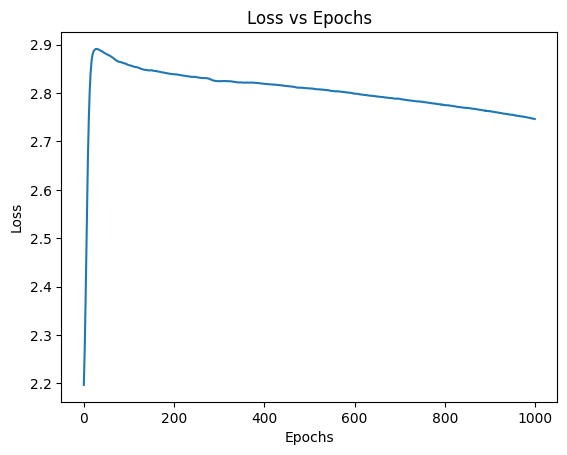

In [297]:
# evaluate the model
loss = mlp.evaluate(X_test, y_test)
print(f"Loss: {loss}")

# predict
y_pred = mlp.predict(X_test)

y_pred = mlp.filter_softmax(y_pred)

# accuracy
accuracy = mlp.accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")


# # atleast one label per sample
# for i in range(y_test.shape[0]):
#     if 

# hamming loss
hamming_loss = mlp.hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming_loss}")

# partial accuracy
y_pred_partial = y_pred.reshape(-1, 1)
y_test_partial = y_test.reshape(-1, 1)
partial_accuracy = mlp.accuracy(y_test_partial, y_pred_partial)
print(f"Partial Accuracy: {partial_accuracy}")

# plot the loss
import matplotlib.pyplot as plt

plt.plot(mlp.loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

In [298]:
def multi_label_confusion_matrix(y_true, y_pred):
    num_labels = y_true.shape[1]
    confusion_matrices = []

    for i in range(num_labels):
        tp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 1))  # True Positive
        tn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 0))  # True Negative
        fp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 0))  # False Positive
        fn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 1))  # False Negative

        matrix = np.array([[tn, fp], [fn, tp]])
        confusion_matrices.append(matrix)

    return np.array(confusion_matrices)

# confusion matrix
confusion_matrix = multi_label_confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# micro-averaged precision, recall, f1_score
micro_precision = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 0]))
micro_recall = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 1]))
micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

print(f"Micro-averaged Precision: {micro_precision}")
print(f"Micro-averaged Recall: {micro_recall}")
print(f"Micro-averaged F1-Score: {micro_f1_score}")



[[[63  0]
  [36  1]]

 [[64  3]
  [29  4]]

 [[60  5]
  [28  7]]

 [[61  3]
  [34  2]]

 [[61  2]
  [37  0]]

 [[76  0]
  [24  0]]

 [[61  0]
  [38  1]]

 [[54 12]
  [24 10]]]
Micro-averaged Precision: 0.2
Micro-averaged Recall: 0.7142857142857143
Micro-averaged F1-Score: 0.3125


In [299]:
def precision_recall_f1(y_true, y_pred):
    epsilon = 1e-9  # To avoid division by zero

    # True Positives, False Positives, and False Negatives for each label
    true_positives = np.sum((y_pred == 1) & (y_true == 1), axis=0)
    false_positives = np.sum((y_pred == 1) & (y_true == 0), axis=0)
    false_negatives = np.sum((y_pred == 0) & (y_true == 1), axis=0)

    # Precision: TP / (TP + FP)
    precision = true_positives / (true_positives + false_positives + epsilon)
    
    # Recall: TP / (TP + FN)
    recall = true_positives / (true_positives + false_negatives + epsilon)
    
    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    # Return macro-average (mean over all labels)
    return precision, recall, f1

precision, recall, f1 = precision_recall_f1(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# macro-average
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-Score: {macro_f1}")

Precision: [1.         0.57142857 0.58333333 0.4        0.         0.
 1.         0.45454545]
Recall: [0.02702703 0.12121212 0.2        0.05555556 0.         0.
 0.02564103 0.29411765]
F1-Score: [0.05263158 0.2        0.29787234 0.09756098 0.         0.
 0.05       0.35714286]
Macro Precision: 0.5011634196345568
Macro Recall: 0.090444172059198
Macro F1-Score: 0.13190096882748073


In [300]:
def multi_label_accuracy(y_true, y_pred):
    # Exact match accuracy (where all labels for a sample are correctly predicted)
    correct_predictions = np.sum(np.all(y_true == y_pred, axis=1))
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

accuracy = multi_label_accuracy(y_test, y_pred)
print(f"Multi-label Accuracy: {accuracy}")

Multi-label Accuracy: 0.01


In [301]:
print(y_test[1] , y_pred[1])
print((y_test[1] == y_pred[1]))
print(np.sum(y_test[1] == y_pred[1]))

[0 1 0 1 0 0 0 1] [0 0 0 0 0 0 0 1]
[ True False  True False  True  True  True  True]
6
